<a href="https://www.kaggle.com/ravi07bec/gentle-intro-with-end-to-end-solution?scriptVersionId=89080251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import pandas_profiling as pp

from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from pandas.api.types import is_string_dtype
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 800)

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

%matplotlib inline
from scipy import stats
from scipy.stats import skew
from pandas.api.types import is_string_dtype

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV


In [3]:
data=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
# Dependent Variable 

data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Learnings from this Competition 

1. Establishing baseline is essential for model improvements 
2. Target and Feature Normalisation(Log or sqrt) leads to lot of improvements 
3. Multiple models are useful to test for accuracy vs complexity tradeoff and correct for overfitting 


In [5]:
test_data=data
test_data['baseline_mean_price']=test_data['SalePrice'].mean()
test_data['abs_error']=100*abs((test_data['SalePrice']-test_data['baseline_mean_price'])/test_data['baseline_mean_price'])

print('Mean Absolute Error Baseline is : ')
round(test_data['abs_error'].mean(),2)

Mean Absolute Error Baseline is : 


31.75

In [6]:
print("Skewness: %f",data['SalePrice'].skew())
print("Kurtosis: %f",data['SalePrice'].kurt())

data['SalePrice'].skew()
from scipy.stats import skew
# skewed_feats = data[num_features].apply(lambda x: skew(x.dropna()))
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats

Skewness: %f 1.8828757597682129
Kurtosis: %f 6.536281860064529


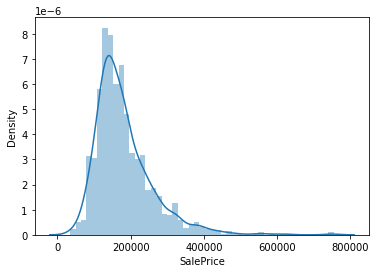

In [7]:
import seaborn as sns
sns.distplot(data['SalePrice']);
plt.show()

In [8]:
# Data Describe
display(data.describe(),data.describe(include = 'object'))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,baseline_mean_price,abs_error
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1.460000e+03,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,1.809212e+05,31.745739
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,6.579719e-09,30.325001
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,1.809212e+05,0.043557
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,1.809212e+05,12.724433
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,1.809212e+05,25.381877
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,1.809212e+05,40.439928
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,1.809212e+05,317.308760


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [9]:
# Missing Values 
combined_data=data.drop('SalePrice',axis=1).append(test_data)
data.isnull().sum().reset_index().sort_values(by=[0],ascending=False)[0:20]

,index,0
72,PoolQC,1453
74,MiscFeature,1406
6,Alley,1369
73,Fence,1179
57,FireplaceQu,690
3,LotFrontage,259
60,GarageFinish,81
64,GarageCond,81
59,GarageYrBlt,81
63,GarageQual,81


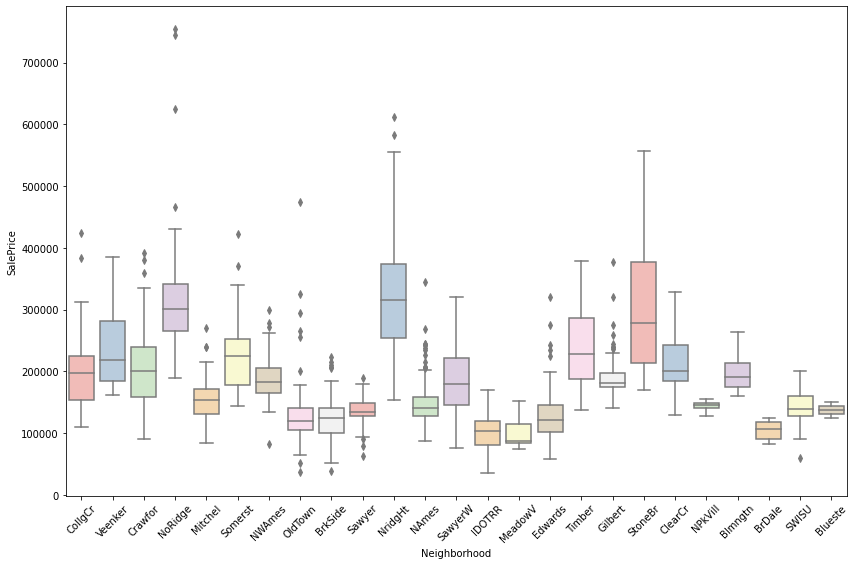

In [10]:
# Box Plot 

f, ax = plt.subplots(figsize=(14, 9))
fig=sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = data,palette='Pastel1')

fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
None

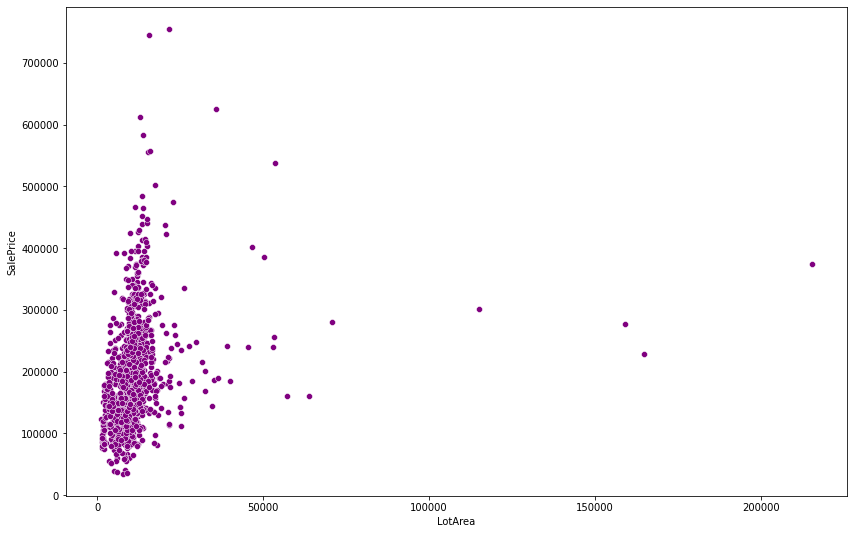

In [11]:
# Scatter Plot 

f, ax = plt.subplots(figsize=(14, 9))

sns.scatterplot(x="LotArea", y="SalePrice", data=data,color='purple')
None

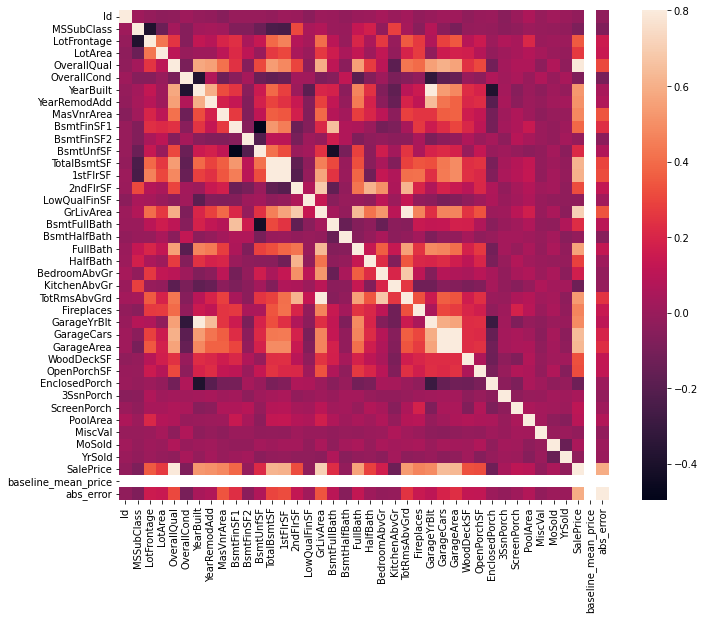

In [12]:
import seaborn as sns
# f,ax= plt.subplots(figsize=(12, 9))
f, ax = plt.subplots(figsize=(12, 9))
corrM = data.corr()

fig=sns.heatmap(corrM,vmax=.8, square=True)


# For Highest Correlation 

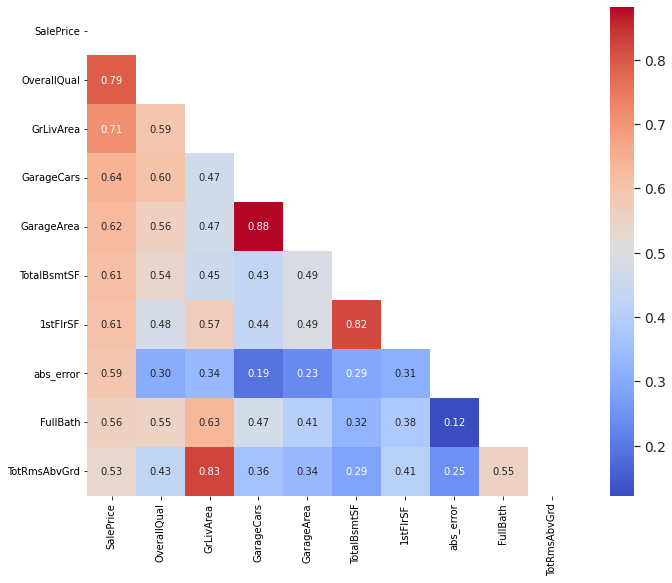

In [13]:
k = 10 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))

corrM = data.corr()
cols = corrM.nlargest(k, 'SalePrice')['SalePrice'].index

matrix = np.triu(data[cols].corr())

cm = np.triu(data[cols].corr())
sns.set(font_scale=1.25)
hm = sns.heatmap(data[cols].corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap='coolwarm',mask=matrix)
plt.show()

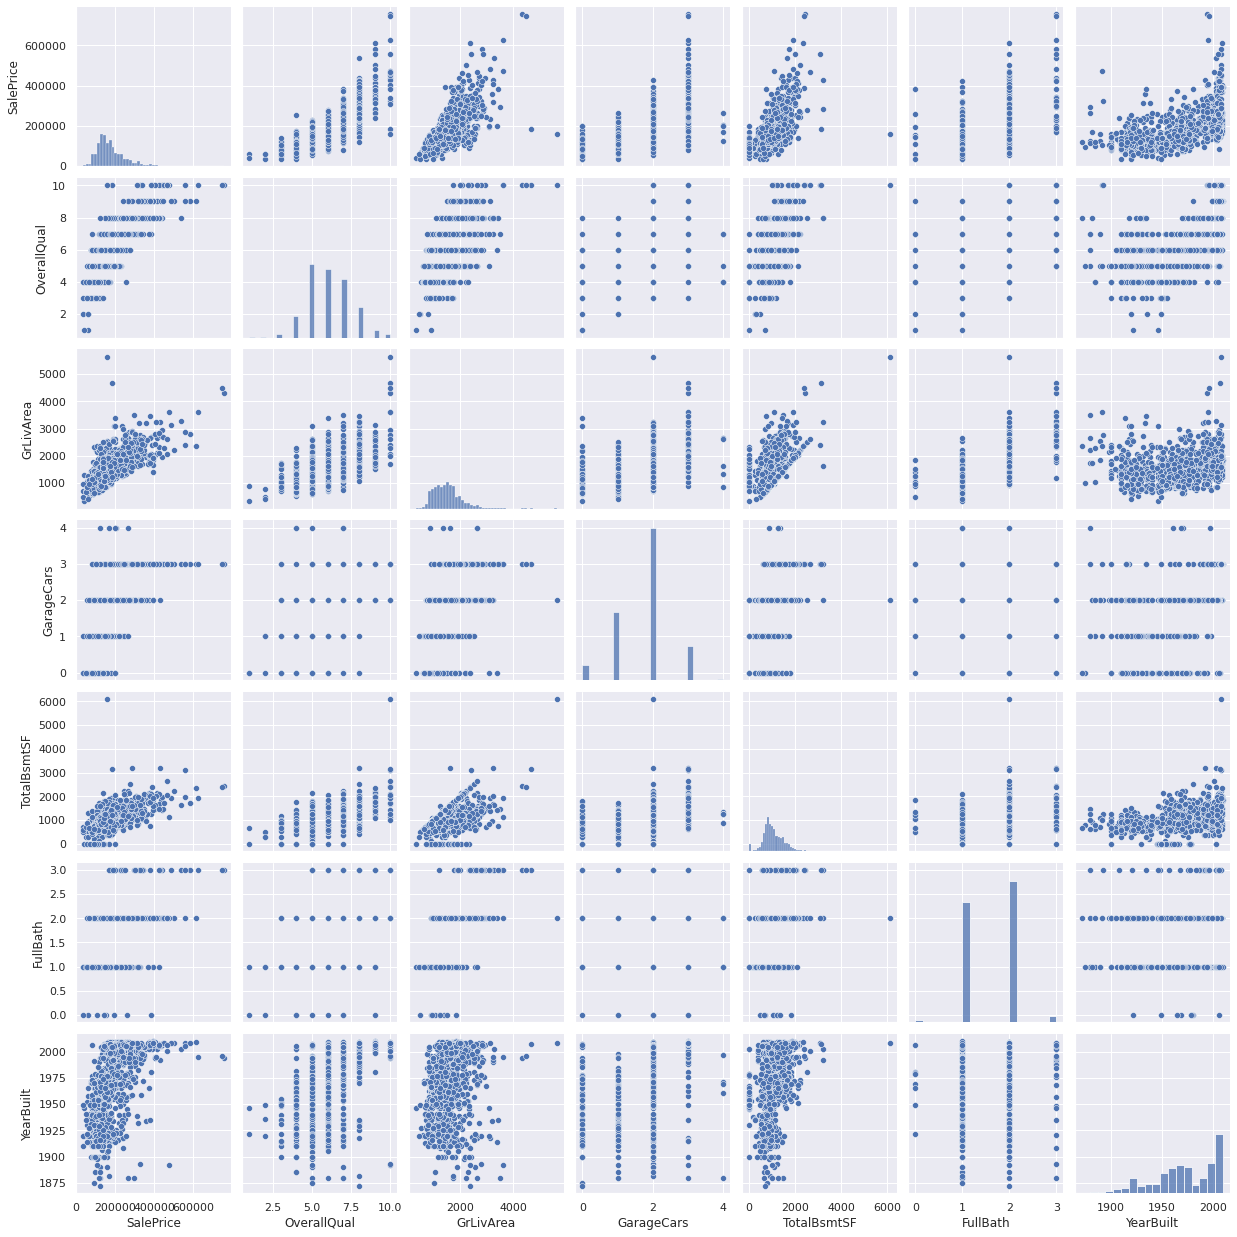

In [14]:
# PairPlot

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data[cols], height = 2.5)
plt.show();

# QQ Plot for normality

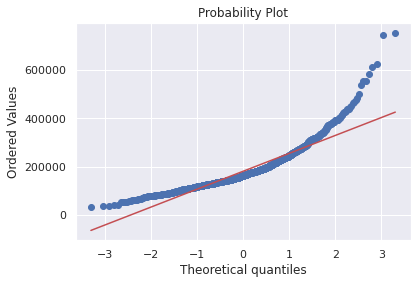

In [15]:
res = stats.probplot(data['SalePrice'], plot=plt)

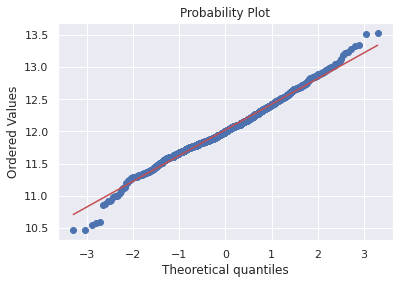

In [16]:
data['SalePrice_log']=np.log(data['SalePrice'])
# r1=sns.distplot(data['SalePrice_log'])
res = stats.probplot(data['SalePrice_log'], plot=plt)
data.drop(['SalePrice_log'],axis=1,inplace=True)

# Missing Value Imputation 

In [17]:
def missing_value_impute(data):
    cols=data.columns

    for i in cols:
        if(is_string_dtype(data[i])):
            data[i]=data[i].fillna(data[i].mode()[0])
        else:
            data[i]=data[i].fillna(data[i].median())
            
    return data

data=missing_value_impute(data)
        

# Categorical Columns Exploratory Data Analysis

In [18]:
cat_columns=[]
for i in cols:
    if(is_string_dtype(data[i])):
        cat_columns.append(i)
        

for i in cat_columns:
    print('sale Price Difference for :',i)
    test1=data.groupby([i])['SalePrice'].mean().reset_index()
    test1['SalePrice']=test1['SalePrice'].astype('int64')
    display(test1)
    print('-'*10, '\n')
    

# Box Plot for Categorical 

In [19]:
for i in cat_columns[0:3]:
    f, ax = plt.subplots(figsize=(12, 9))
    fig=sns.boxplot(x = i, y = 'SalePrice', data = data,palette='Pastel1')
    fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
   
    

In [20]:
# num_features=[]
# for i in cols:
#     if(is_string_dtype(data[i])):
#         next
        
#     else:
#         num_features.append(i)

# num_features.remove('SalePrice')

# fig,axes = plt.subplots(2,2,figsize=(18,15))
# for seg,col in enumerate(num_features[:len(num_features)-1]):
    
#     x,y = seg//4,seg%4
#     sns.regplot(x=col, y='SalePrice' ,data=data,ax=axes[x][y],color='g')

In [21]:
def label_ecoding(data):
    label = LabelEncoder()
    for i in cat_columns:
        if( i not in (['SalePrice'])):
            feature=i+'_Code'
            data[feature] = label.fit_transform(data[i])
            
    return data

test_data=missing_value_impute(test)


data=label_ecoding(data)
# cat_features.append(['SK_ID_CURR'])
cat_columns=cat_columns+['SalePrice']
y=data['SalePrice']
data_x=data.drop(cat_columns,axis=1)
data_x=pd.get_dummies(data_x)


# Preparing test Dataset for Model Prediction

In [22]:

test_data=label_ecoding(test_data)
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Gd,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Gd,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,Ex,MnPrv,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,Ex,MnPrv,Shed,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Gd,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,Ex,MnPrv,Shed,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,Gd,Attchd,1979.0,Unf,0.0,0.0,TA,TA,Y,0,0,0,0,0,0,Ex,MnPrv,Shed,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,Gd,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,Ex,MnPrv,Shed,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,Ex,MnPrv,Shed,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1

# Building Multiple models with custom loss function 

In [23]:
from sklearn.metrics import fbeta_score, make_scorer
def my_custom_loss_func(y_true, y_pred):
    diff = 100*np.abs((y_true - y_pred)/y_true)
    return -np.mean(diff)



score1 = make_scorer(my_custom_loss_func, greater_is_better=False)

score2=['neg_mean_absolute_error']


models=[LinearRegression(),DecisionTreeRegressor(max_depth=4),RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
labels=['Linear_Regression','Decision_Tree','Random_Forest','AdaBoost','Gradient_Boost','XGBoost']

performance_final=pd.DataFrame()
for i in range(0,len(models)):
    print('Running Model:',labels[i])
    model=models[i]
    cv_results = cross_validate(model, data_x, y, cv  = 5,return_train_score=True,scoring=score1)
    
    metrics=pd.DataFrame(cv_results).mean().reset_index()
    metrics['model_name']=labels[i]
    performance=pd.DataFrame(metrics.pivot_table(index='model_name',columns='index', values=0).to_records())
    
    performance_final=performance_final.append(performance)
    

Running Model: Linear_Regression
Running Model: Decision_Tree
Running Model: Random_Forest
Running Model: AdaBoost
Running Model: Gradient_Boost
Running Model: XGBoost


In [24]:
performance_final

,model_name,fit_time,score_time,test_score,train_score
0,Linear_Regression,0.083152,0.014073,7201.758267,7.226578
0,Decision_Tree,0.032396,0.006266,10.633030,9.915304
0,Random_Forest,2.785884,0.017652,4.669351,1.709884
0,AdaBoost,0.680629,0.016782,11.792301,11.140569
0,Gradient_Boost,1.075984,0.006351,5.982826,3.795018
0,XGBoost,1.153651,0.014699,4.666400,0.235719


In [25]:
eval_metric_model='test_score'
performance_final[eval_metric_model]= round(performance_final[eval_metric_model],3)
performance_final=performance_final.sort_values(by=[eval_metric_model],ascending=False)
px.bar(performance_final,x='model_name',y=eval_metric_model,text=eval_metric_model)

In [26]:
# Feature Importance
import difflib
model=XGBRegressor()
model.fit(data_x, y)
fi = pd.DataFrame({'feature': list(data_x.columns),
                   'importance': 100*model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
4,OverallQual,41.459160
38,abs_error,16.208115
251,GarageFinish_Unf,10.559770
226,Electrical_SBrkr,6.754174
16,GrLivArea,3.466168
230,KitchenQual_TA,3.022425
43,MSZoning_RM,1.829947
24,Fireplaces,1.628014
248,GarageType_Detchd,1.182875
5,OverallCond,0.814277
